# Homework 1#
#### Reading in 3 sources of data
1. Importing a csv data set (monthly stock returns)
2. using pandas datareader to get data from a website (monthly returns for the stock market and the risk-free rate)
3. Getting data via API (gasoline prices from the department of energy)

#### Cleaning, Describing, and Visualizing each source


### 1. CSV
- This data comes from the CRSP database of stock returns. It includes date, permno (identifies the company) share code (shrcd) tells us what type of stock it is, prc (price), ret (return), share class (shrcls) isn't relevant for our analysis

In [1]:
import pandas as pd
import numpy as np

Read in the data into a dataframe. Delete an irrelevant column and missing observations, parse dates
This data set is very good, there are only a few missing values and they will be irrelevant the way that we are going to aggregate the data. Basically the point of this type of financial analysis is to be able to form portfolios based on data that would have been available historically at the time, thus dropping missing observations is fine because somebody making financial decisions at the time wouldn't have had that data.

In [5]:
df = pd.read_csv('monthly stock file.csv',parse_dates=['date'])
df.columns = ['permno','date','shrcd','name','shrcls','prc','ret','shrout']
del df['shrcls']
df = df.dropna()
df.head(5)

,permno,date,shrcd,name,prc,ret,shrout
0,10001,1990-01-31,11.0,GREAT FALLS GAS CO,-9.9375,-0.018519,1022.0
1,10001,1990-02-28,11.0,GREAT FALLS GAS CO,-9.8750,-0.006289,1022.0
2,10001,1990-03-30,11.0,GREAT FALLS GAS CO,-9.8750,0.012658,1027.0
3,10001,1990-04-30,11.0,GREAT FALLS GAS CO,-9.8750,0.000000,1027.0
4,10001,1990-05-31,11.0,GREAT FALLS GAS CO,9.7500,-0.012658,1027.0


In financial research we often exclude low priced stocks, based on the price in the previous period.
- first we create a variable with lagged price
- then we drop low priced stocks based on lagged price
- low priced stocks are dropped because they don't tell us much about the market as a whole (often have low market cap) and they often behave strangely
- We drop based stocks based on the prior periods return because we want to utilize methods that would have been available at the time.
- we also drop negative priced stocks, this is a code in the date for not having an accurate price
- we also check for returns coded as "B" or "C", these are common codes for missing returns. We will drop these.

In [6]:
df['prc_lag'] = df.groupby('permno')['prc'].shift(1)
df = df.query('prc_lag >= 5 & prc >= 0 & ret != "B" & ret != "C"')


We need to calculate the market equity of each stock. This represents how large the company is
- We calculate Market Equity by multiplying the share price by the number of shares outstanding (prc*shrout)

In [7]:
df['me'] = df['prc']*df['shrout']

With this data, we only want common stock (stocks with share code 11 or 12). We will also reset the index

In [8]:
df = df.query("shrcd ==11 | shrcd == 12").reset_index(drop = True)

next we want to sort our securities each month into 5 portfolios based on lagged market equity
- This allows us to essentially compare small companies to larger companies based on returns
- we create a market equity lagged variable
- we then create a port variable with values 0, 1, 2, 3, or 4, assigning each stock to a quintile based portfolio 

In [9]:
df['me_lag'] = df.groupby('permno')['me'].shift(1)
df['port'] = df.groupby('date')['me_lag'].transform(pd.qcut,5,labels=False, duplicates = 'drop')

Now we have a port variable with values 0-4 indicating which portfolio the security belongs to at each date

We can now get portfolio returns at each date by aggregating stock returns in a pivot table
- first we cast the return column as a float so that we can aggregate
- next we create our pivot table called port_returns
- we multiply the pivot table by 100 so the returns are in percent, for example 4.2 corresponds to 4.2%

In [45]:
df['ret'] = df['ret'].astype(float)
port_returns = df.pivot_table('ret','date',columns='port',aggfunc='mean')*100


It's helpful to rename the columns using a list comprehension

We can also create a "spread" portfolio. This portfolio is created by taking the difference of p4 and p0 at each date. It represents a trading strategy in which we would short the large company portfolio and long the small company portfolio

In [46]:
port_returns.columns = ['p' + str(int(x)) for x in port_returns.columns]
port_returns = port_returns.reset_index()
port_returns['spread'] = port_returns['p0'] - port_returns['p4']

Now we can use a nice custom summary statistic function to summarize each portfolio
- this function reports the mean, standard deviation, and tstat (comparing the return to zero) for each portfolio

In [47]:
def summary(p):
    s = p.describe().T
    s['tstat'] = s['mean']/(s['std']/np.sqrt(s['count']))
    return s[['mean','std','tstat']].T

summary(port_returns)

,p0,p1,p2,p3,p4,spread
mean,1.096350,1.074522,1.005051,0.997161,0.937689,0.158661
std,4.792220,5.940763,6.006435,5.458381,4.617349,2.877721
tstat,4.105257,3.245645,3.002611,3.278154,3.644131,0.989347


Notice there are significant differences between the smallest and largest portfolios. This is a common result. We see that the portfolio of small companies brings in a monthely return of 1.09% while the portfolio of large companies brings in a return of .93%. We see this difference reflected in the .15% monthly return on the spread portfolio.

finally we can graph portfolio returns over time

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

I will now construct a head map for the spread returns over each month and year. 

It would be interesting to see if these differences in returns between large and small companies is periodic or more or less pronounced during different times of the year. 

C:\Users\jonathanjensen\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\jonathanjensen\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Text(0.5,1,'Spread Return Periodicity')

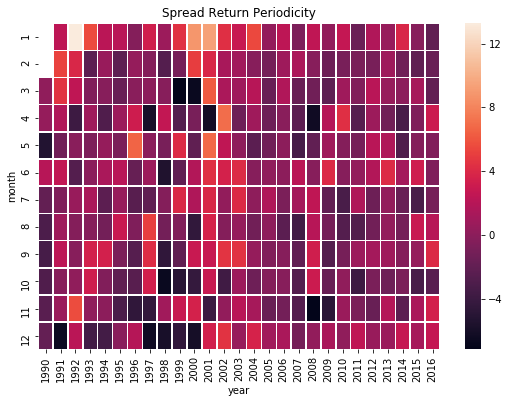

In [60]:
spread = port_returns[['date','spread']]
spread['month'] = spread['date'].dt.month
spread['year'] = spread['date'].dt.year
pivot = spread.pivot("month", "year", "spread")
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot, annot=False, linewidths=.5, ax=ax).set_title("Spread Return Periodicity")

We can see that there doesn't really seem to be a significant pattern in the data across the same months in different years, but we can see some years like 2001 where all of the months seem to show large effects. 

It's also nice to just get a line graph of the spread return over the time sample

In [61]:
port_returns = port_returns.reset_index()
x = port_returns['date']
y1 = port_returns['spread']


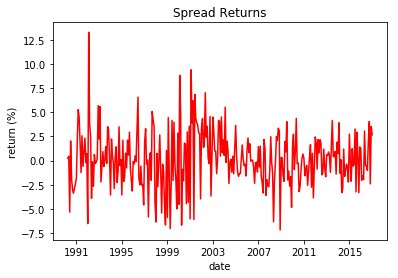

In [65]:
plt.title('Spread Returns')
plt.xlabel("date")
plt.ylabel("return (%)")
plt.plot(x, y1, 'r')

### 2. Datareader

In [67]:
from pandas_datareader.data import DataReader


In [68]:
start = '1927-01'
fac = DataReader("F-F_Research_Data_Factors", "famafrench",start=start)[0]
fac['caldt'] = fac.index.to_timestamp()
fac = fac[['caldt','Mkt-RF','RF']].reset_index(drop=True)
fac = fac.rename(columns={'Mkt-RF':'exmkt','RF':'rf'})
fac.tail()

,caldt,exmkt,rf
1087,2017-08-01,0.16,0.09
1088,2017-09-01,2.51,0.09
1089,2017-10-01,2.25,0.09
1090,2017-11-01,3.12,0.08
1091,2017-12-01,1.06,0.09


we want to limit the date range of this sample to match our previous data set

In [69]:
fac = fac.query('caldt > "1990-01-01"')

This data set contains monthly portfolio returns that capture important effects

- exmkt: The return on a portfolio containing all common stocks

- rf: The risk free rate in the market

We can graph and summarize these variables

In [70]:
summary(fac)

,exmkt,rf
mean,0.683701,0.226925
std,4.207892,0.192973
tstat,2.973886,21.523261


Notice in the graph below that the excess market return is quite volatile, while the risk-free rate is very constant.

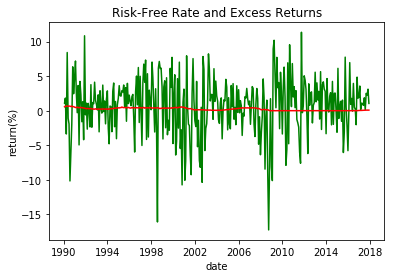

In [71]:
x = fac['caldt']
y1 = fac['exmkt']
y2 = fac['rf']
plt.title("Risk-Free Rate and Excess Returns")
plt.ylabel("return(%)")
plt.xlabel("date")
plt.plot(x,y1,'g',x,y2,'r')

We might want to merge both of the data sets above to conduct further analysis
- each of the data sets fac and port_returns are on a monthly level
- pandas reads in both sets with a day variable. The days are meaningless, however, they don't match
- we will create a new year month variable to merge the two data sets on
- both data sets will have a yearmonth variable in the format yyyymm

In [72]:
fac['yearmonth'] = fac['caldt'].map(lambda x: 100*x.year + x.month)
port_returns['yearmonth'] = port_returns['date'].map(lambda x: 100*x.year + x.month)
merged_data = port_returns.merge(fac, on = "yearmonth", how = "left")

In [73]:
merged_data.head()

,index,date,p0,p1,p2,p3,p4,spread,yearmonth,caldt,exmkt,rf
0,0,1990-03-30,2.712937,3.718324,4.249091,2.723127,2.466531,0.246406,199003,1990-03-01,1.83,0.64
1,1,1990-04-30,-3.626120,-2.814045,-3.092009,-4.266629,-4.073740,0.447620,199004,1990-04-01,-3.36,0.69
2,2,1990-05-31,4.182802,6.617421,8.209032,8.424287,9.515312,-5.332510,199005,1990-05-01,8.42,0.68
3,3,1990-06-29,1.134338,1.851190,0.145307,-0.339569,-0.903709,2.038047,199006,1990-06-01,-1.09,0.63
4,4,1990-07-31,-3.588767,-4.081665,-3.890012,-3.723686,-1.620808,-1.967960,199007,1990-07-01,-1.90,0.68


- We could now look at how the portfolio returns covary with the market return, or a variety of other questions
- Generally we would approach this by regressing the spread portfolio return on the excess market return. Some asset pricing models claim that the excess market return should be the sole driver of all portfolio returns, thus if the regression reports a significant intercept return it could be a sign of market inefficiency. 

It could be interesting to look at the distribution of excess market returns over time using a histogram and kernel density. 

[Text(0.5,0,'exmkt'), Text(0.5,1,'Excess Market Return Distribution')]

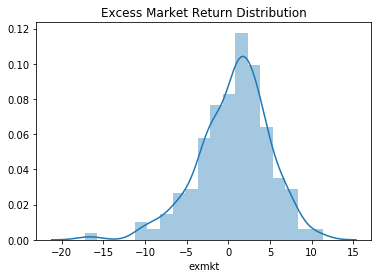

In [79]:
sns.distplot(merged_data.exmkt, kde=True).set(title = "Excess Market Return Distribution", xlabel = "exmkt")

This graph looks about right. Monthly stock returns are generally normally distributed. Notice the distribution is skewed left. 

### 3. API

In [80]:
import json
import requests

I found some nice energy data on gas prices

I had to register and recieve a key in order to make the api request

Below I am reading the data and getting it into json

In [81]:
api_url = "http://api.eia.gov/series/?api_key=1ca12924e78e6d480f3a01b0cc96fc65&series_id=PET.EMM_EPMRR_PTE_NUS_DPG.M"
api_request = requests.get(api_url)
api_dict = api_request.json()

The data was formatted in a strange way, I turn it into a series of tuples

I then apply pd.Series to get a dataframe with 2 columns which I name date and price (gas price)

In [82]:
series = api_dict['series']
x = pd.Series(series[0]['data'])
gas = x.apply(pd.Series)
gas.columns = ['caldt','price']

There is at least one date with an empty price, I take care of those observations here.

I also format the date to match up with the above stock data

In [83]:
gas = gas.dropna()
gas['caldt'] = pd.to_datetime(gas['caldt'], format = "%Y%m")
gas.head()

,caldt,price
0,2017-12-01,2.663
1,2017-11-01,2.751
2,2017-10-01,2.663
3,2017-09-01,2.802
4,2017-08-01,2.557


We can now look at some summary statistics of gasoline prices

1. Prices in the entire date range
2. Prices after 2010

In [84]:
gas['price'].describe()

count    277.000000
mean       2.275473
std        0.916669
min        0.984000
25%        1.461000
50%        2.267000
75%        2.991000
max        4.190000
Name: price, dtype: float64

In [85]:
gas.query("caldt >= '2010-01-01'")['price'].describe()

count    96.000000
mean      3.109323
std       0.584712
min       1.936000
25%       2.572000
50%       3.037500
75%       3.693500
max       4.032000
Name: price, dtype: float64

Next we can graph gasoline prices

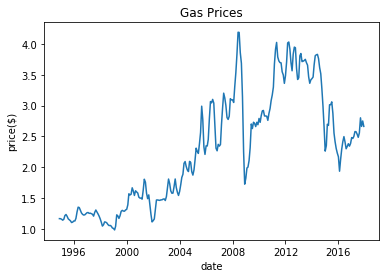

In [86]:
plt.xlabel('date')
plt.ylabel('price($)')
plt.title("Gas Prices")
plt.plot(gas['caldt'],gas['price'])

Now we can merge gasoline prices with our monthly market if we wanted to conduct further analysis (like how gas prices covary with the stock market)

In [87]:
merge = gas.merge(fac, on = 'caldt',how = 'right')


We can also construct a heat map to look at gas prices over time

Text(0.5,1,'GAS PRICES')

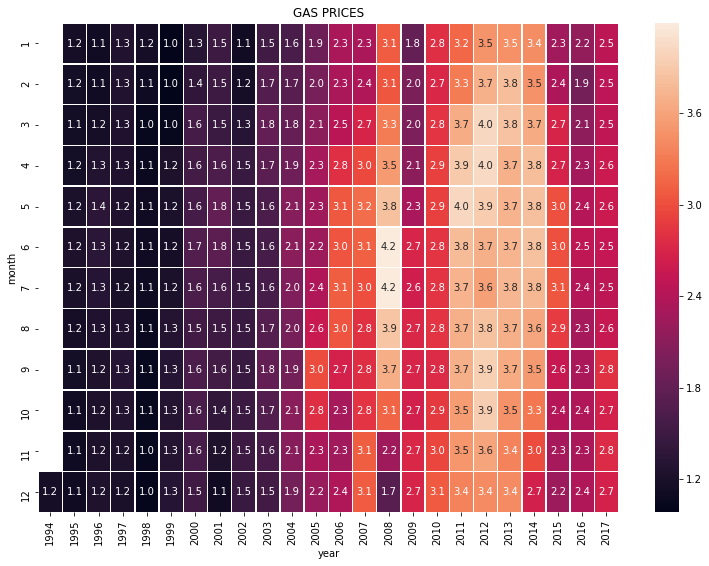

In [92]:
gas['year']=gas['caldt'].dt.year
gas['month']=gas['caldt'].dt.month
gas_pivot = gas.pivot("month", "year", "price")

f, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(gas_pivot, annot=True, fmt=".1f", linewidths=.5, ax=ax).set_title("GAS PRICES")

Notice that gas prices seem to trend up in the summer months, and in certain years

### The End
- Hopefully I completed all of the requirements for this assignment
- I had never used json or api's before, so this was actually pretty cool.